In [1]:
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# Import libraries
import os
import xlrd
import math
import zipfile
import numbers
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from pathlib import Path
import time
from ctgan import TableganSynthesizer
from sklearn.model_selection import train_test_split

In [3]:
num_epochs = 300

In [4]:
home = str(Path.home())

In [5]:
home

'C:\\Users\\stazt'

In [6]:
# Load cleaned 2016-2018 OVS datasets; replace NAs by -1
OVS1618 = pd.read_csv(home + '/Documents/nBox/Project Ultron/Milestone 3/Dataset/Cleaned (Outliers Removed)/Reduced to Benchmarks-1.csv')

In [7]:
OVS1618.head()

,Expenditure on Accommodation (c4.tot.new),Expenditure on Accommodation (c4.tot.new)_cat,Expenditure on F&B (c6.tot.new),Expenditure on F&B (c6.tot.new)_cat,"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)","Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat",Expenditure on Casual Dining (c6c_2.r),Expenditure on Casual Dining (c6c_2.r)_cat,Expenditure on Transport (c7.tot.new),Expenditure on Transport (c7.tot.new)_cat,...,Mode of Transport (m1),Main POV - Leisure/Holiday (b13a_112),Main POV - Visiting Friends/Family (b13a_114),Main POV - Business (b13a_116),Main POV - Healthcare (b113_117),Main POV - Education/Training/Workshop (b13a_118),Main POV - Others (b13a_119),Travel Package (c1a),"Accommodation - Hotels (c4a_1, c4a_2, c4a_3)","Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)"
0,679.04,0,400.0,0,-1.0,1,400.0,0,50.0,0,...,1,1,0,0,0,0,0,1,1,0
1,-1.00,1,130.0,0,100.0,0,30.0,0,100.0,0,...,1,1,1,0,0,0,0,2,0,0
2,-1.00,1,120.0,0,120.0,0,-1.0,1,40.0,0,...,1,0,0,0,0,0,0,2,0,0
3,-1.00,1,80.0,0,-1.0,1,80.0,0,100.0,0,...,1,1,1,0,0,0,0,2,0,0
4,130.00,0,60.0,0,60.0,0,-1.0,1,40.0,0,...,1,1,0,0,0,0,0,2,0,1


In [8]:
OVS1618.shape

(66030, 38)

In [9]:
# List of 14 expenditure variables
list_expnd = ['Expenditure on Accommodation (c4.tot.new)',
              'Expenditure on F&B (c6.tot.new)',
              'Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)',
              'Expenditure on Casual Dining (c6c_2.r)',
              'Expenditure on Transport (c7.tot.new)', 
              'Expenditure on Sightseeing & Entertainment (c10.tot.new)',
              'Expenditure on Sightseeing (c10c_1.r)',
              'Expenditure on Attractions (c10c_2.r)',
              'Expenditure on Shopping (t7.m.any)',          
              'Expenditure on Healthcare & Wellness Products (t7.m.well)',
              'Expenditure on Confectionery & Food Items (t7.m.food)',
              'Expenditure on Fashion (t7.m.fash)',
              'Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)',
              'Package Expenditure Per Person (c1b.r)']

# List of 10 categorical variables
list_cat = ['Mode of Transport (m1)',
            'Main POV - Leisure/Holiday (b13a_112)',
            'Main POV - Visiting Friends/Family (b13a_114)',
            'Main POV - Business (b13a_116)',
            'Main POV - Healthcare (b113_117)',
            'Main POV - Education/Training/Workshop (b13a_118)',
            'Main POV - Others (b13a_119)',
            'Travel Package (c1a)',
            'Accommodation - Hotels (c4a_1, c4a_2, c4a_3)',
            'Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)']

In [10]:
with open(home + '/Documents/nBox/Project Ultron/Milestone 3/Dataset/Cleaned (Outliers Removed)/binary_categorical_columns.txt',"r+")   as f:
    new_cat_list = f.read().splitlines() 

In [11]:
new_cat_list

['Expenditure on Accommodation (c4.tot.new)_cat',
 'Expenditure on F&B (c6.tot.new)_cat',
 'Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat',
 'Expenditure on Casual Dining (c6c_2.r)_cat',
 'Expenditure on Transport (c7.tot.new)_cat',
 'Expenditure on Sightseeing & Entertainment (c10.tot.new)_cat',
 'Expenditure on Sightseeing (c10c_1.r)_cat',
 'Expenditure on Attractions (c10c_2.r)_cat',
 'Expenditure on Shopping (t7.m.any)_cat',
 'Expenditure on Healthcare & Wellness Products (t7.m.well)_cat',
 'Expenditure on Confectionery & Food Items (t7.m.food)_cat',
 'Expenditure on Fashion (t7.m.fash)_cat',
 'Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)_cat',
 'Package Expenditure Per Person (c1b.r)_cat']

In [12]:
cat_cols = new_cat_list + list_cat

In [13]:
len(cat_cols)

24

In [14]:
## split data into training/validation/test
OVS1618_train_val, OVS1618_test = train_test_split(OVS1618, test_size=0.15, random_state=42)

In [15]:
OVS1618_train_val.shape

(56125, 38)

In [16]:
OVS1618_test.shape

(9905, 38)

In [17]:
tablegan =  TableganSynthesizer()
print('Training tableGAN is starting')
start_time = time.time()
tablegan.fit(OVS1618_train_val, discrete_columns=cat_cols, epochs=num_epochs, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training tableGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of epochs:  300
Depth of layer:  0
training data shape:  (46247, 38)
validation data shape:  (9878, 38)
num_components 12
num_components 13
num_components 14
num_components 15
num_components 13
num_components 12
num_components 10
num_components 14
num_components 14
num_components 11
num_components 13
num_components 11
num_components 11
num_components 7
data shape (46247, 233)
data dim 233
side 16
Epoch 1, Loss G: 2.7073, Loss D: 0.1665


In [18]:
print(f'Time taken: {elapsed_time}')

Time taken: 504.38822770118713


In [19]:
tablegan_samples = tablegan.sample(OVS1618_test.shape[0],condition_column=None, condition_value=None)

In [20]:
## save generated data
Path(home + r'/Documents/nBox/Project Ultron/Milestone 4/code/tableGAN').mkdir(parents=True, exist_ok=True)
tablegan_samples.to_csv(home + r'/Documents/nBox/Project Ultron/Milestone 4/code/tableGAN/tablegan_samples.csv', index=False, header=True)

In [21]:
## save model
tablegan.save(home + '/Documents/nBox/Project Ultron/Milestone 4/code/tableGAN/tablegan.pkl')

In [22]:
def data_cleaning(df):
    df_new = df.copy()
    for expnd in list_expnd:
        df_new[expnd] = df_new[expnd].mask(df_new[expnd+'_cat'] == 1)
        df_new[expnd] = df_new[expnd].mask(df_new[expnd] <= 0)
    return df_new

In [23]:
tablegan_samples_cleaned = data_cleaning(tablegan_samples)

## Plots of continuous benchmarks

In [24]:
def plots(original_data, synthetic_data, list_expnd):
    for col in list_expnd:
        prop = round(sum(original_data[col+'_cat'])/len(original_data[col+'_cat'])*100,2)
        plt.suptitle(col + " " + str(prop) +'% NAs')
              
        sns.kdeplot(original_data[col],shade=True, label='Original')
        if len(synthetic_data[col].unique()) > 1:
            sns.kdeplot(synthetic_data[col],shade=True, label='Synthetic')
        plt.legend();
        plt.show()

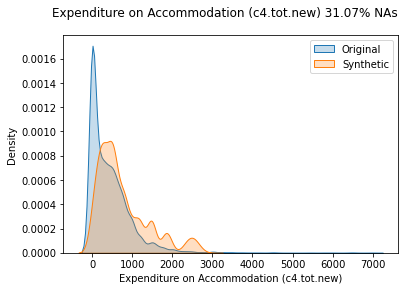

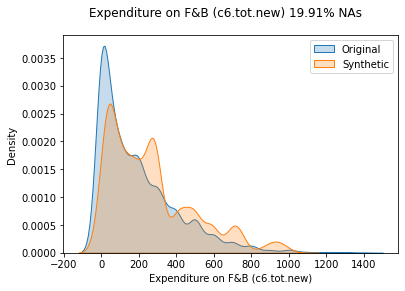

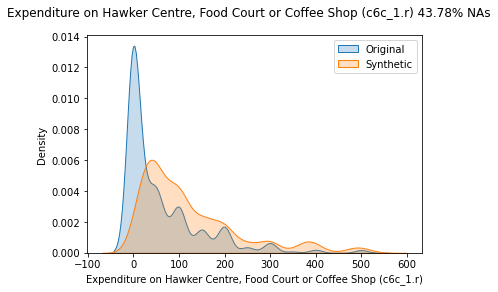

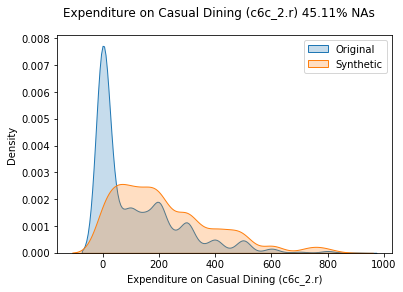

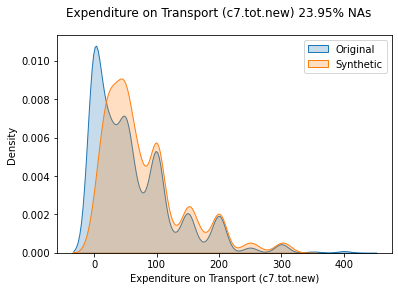

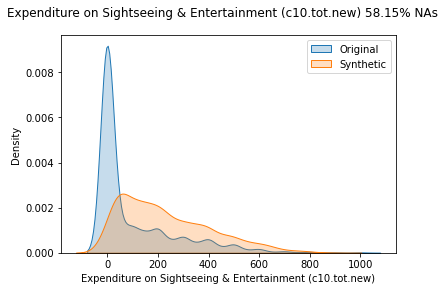

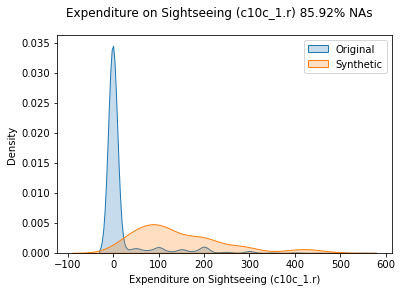

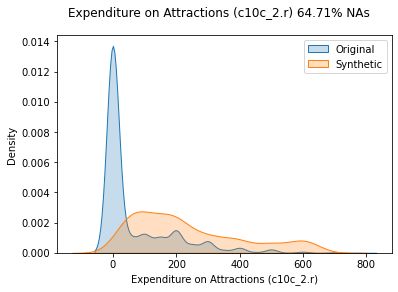

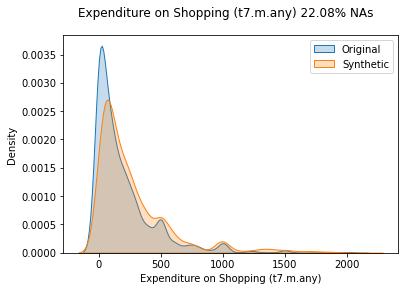

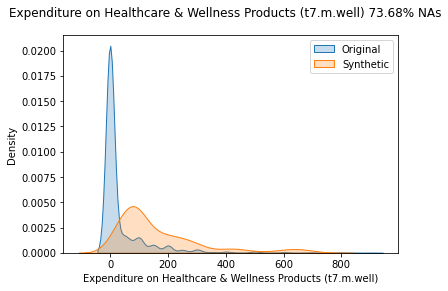

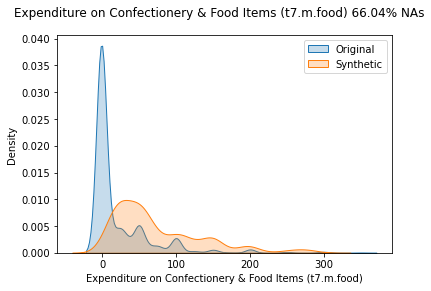

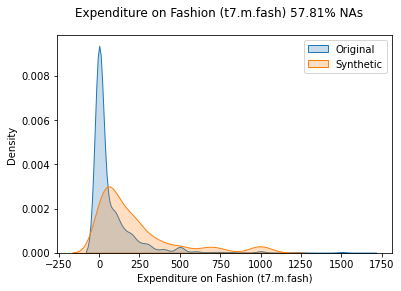

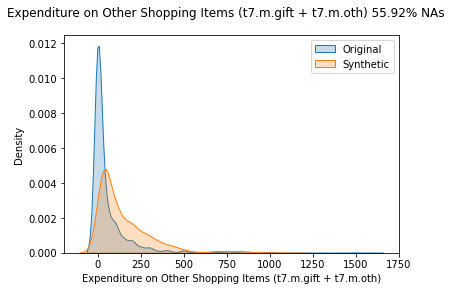

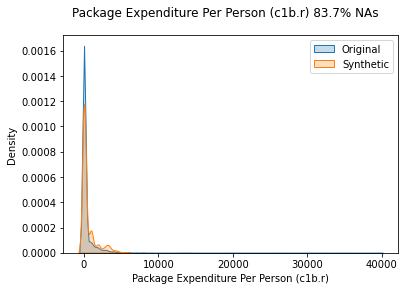

In [25]:
plots(OVS1618_test,tablegan_samples_cleaned,list_expnd)

## Plots of categorical benchmarks

In [26]:
def plot_bar(ovs, vgm1, cat_cols):
     for col in cat_cols:   
        width = 0.1
        xlab = np.asarray(ovs[col].value_counts().index)
        plt.bar(xlab,ovs[col].value_counts(), color='g', label='Original Data',width=width)
        plt.bar(xlab+width,vgm1[col].value_counts(), color='b', label='Synthetic Data',width=width)        
        plt.title(col)
        plt.legend();

        plt.show()

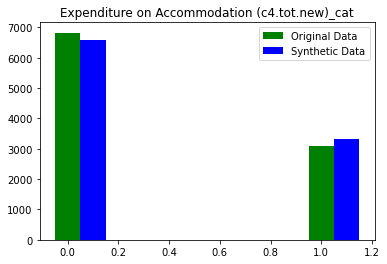

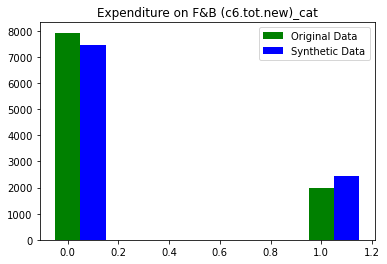

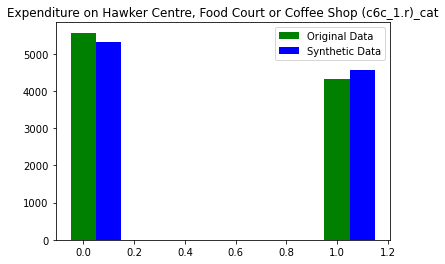

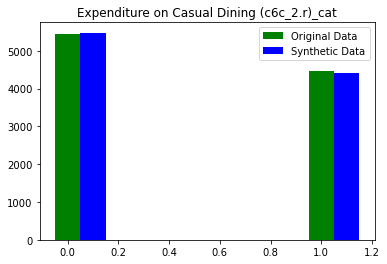

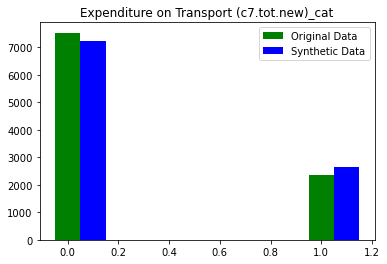

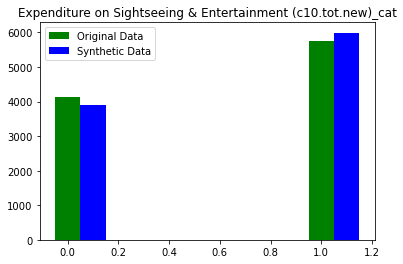

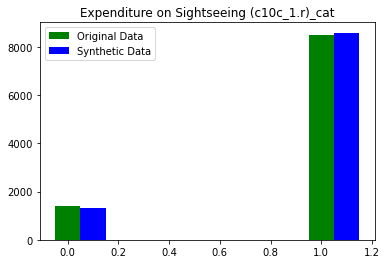

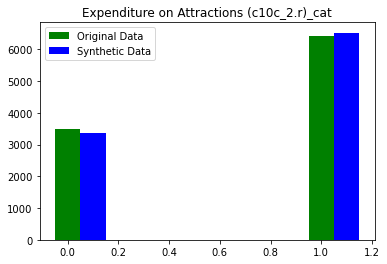

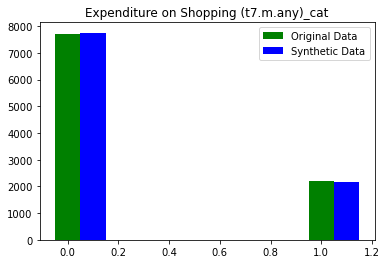

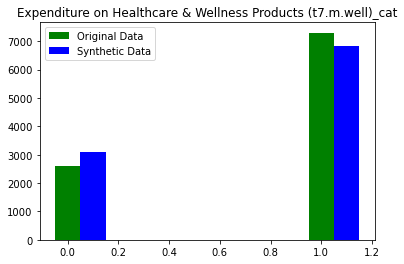

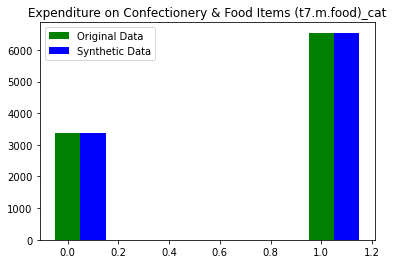

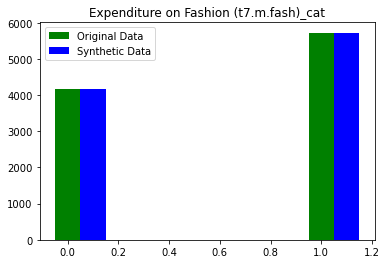

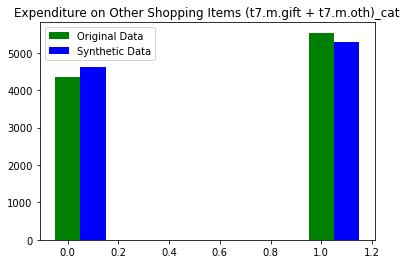

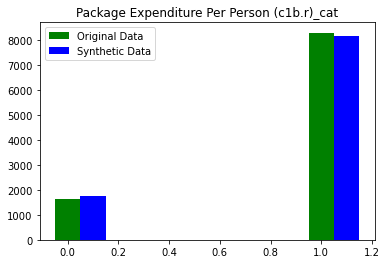

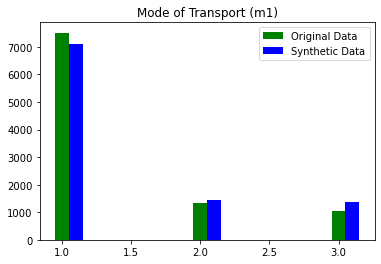

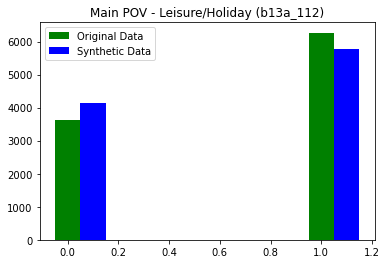

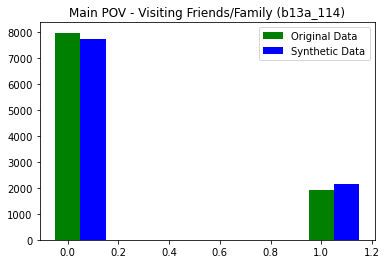

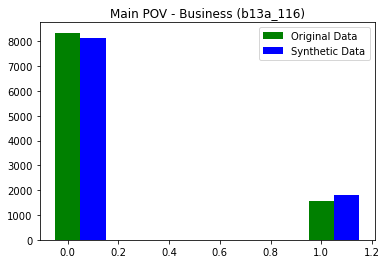

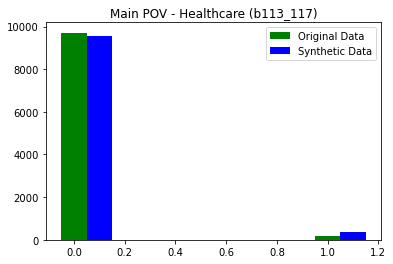

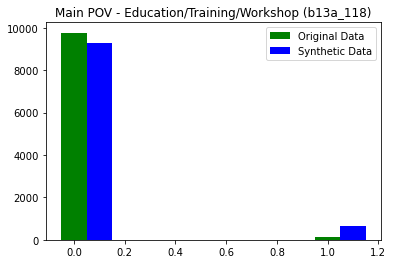

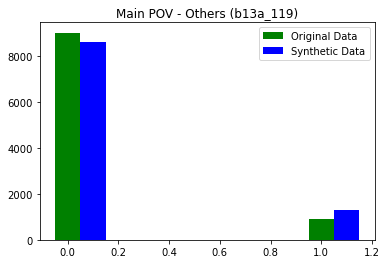

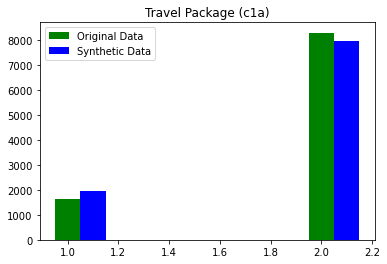

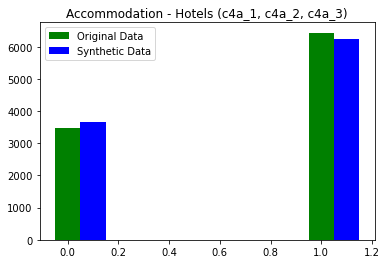

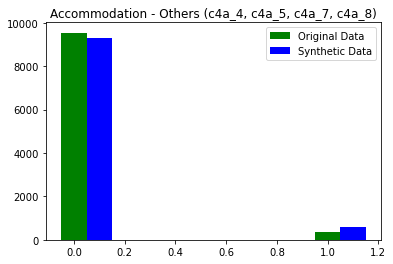

In [27]:
plot_bar(OVS1618_test,tablegan_samples_cleaned,cat_cols)